In [39]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
from langchain import hub
from langchain.agents import (
    AgentExecutor,
    create_react_agent,
)
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI

# API KEY 정보로드
load_dotenv()

In [43]:
from langchain_openai import ChatOpenAI

gpt = ChatOpenAI(model="gpt-4o", temperature=0)

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

# TavilySearchResults 클래스의 인스턴스를 생성합니다. 결과는 3개 갖고 옵니다.
search = TavilySearchResults(k=3)

In [41]:
# 디렉토리에 있는 텍스트 파일을 모두 로딩
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import TextLoader

directory = "data/*.txt"

loader = DirectoryLoader(".", glob=directory, show_progress=True)
docs = loader.load()

print(f"문서의 수: {len(docs)}\n")

100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


In [44]:
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

# 텍스트를 600자 단위로 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=50)
# 문서를 로드하고 분할합니다.
split_docs = loader.load_and_split(text_splitter)
# VectorStore를 생성합니다.
vector = FAISS.from_documents(split_docs, OpenAIEmbeddings())
# Retriever를 생성합니다.
retriever = vector.as_retriever()

100%|██████████| 24/24 [00:08<00:00,  2.75it/s]


In [45]:
# langchain 패키지의 tools 모듈에서 retriever 도구를 생성하는 함수를 가져옵니다.
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    name="txt_search",
    description="디렉토리에 저장된 텍스트 파일을 검색합니다. 질문에 대한 대답은 찾을때 사용합니다.",
)

In [49]:
tools = [retriever_tool, search]

In [51]:
from langchain import hub

# hub에서 prompt를 가져옵니다 - 이 부분을 수정할 수 있습니다!
prompt = hub.pull("hwchase17/openai-functions-agent") # template='You are a helpful assistant'

In [52]:
from langchain.agents import create_openai_functions_agent

# OpenAI 함수 기반 에이전트를 생성합니다.
# llm, tools, prompt를 인자로 사용합니다.
agent = create_openai_functions_agent(gpt, tools, prompt)

In [53]:
from langchain.agents import AgentExecutor

# AgentExecutor 클래스를 사용하여 agent와 tools를 설정하고, 상세한 로그를 출력하도록 verbose를 True로 설정합니다.
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

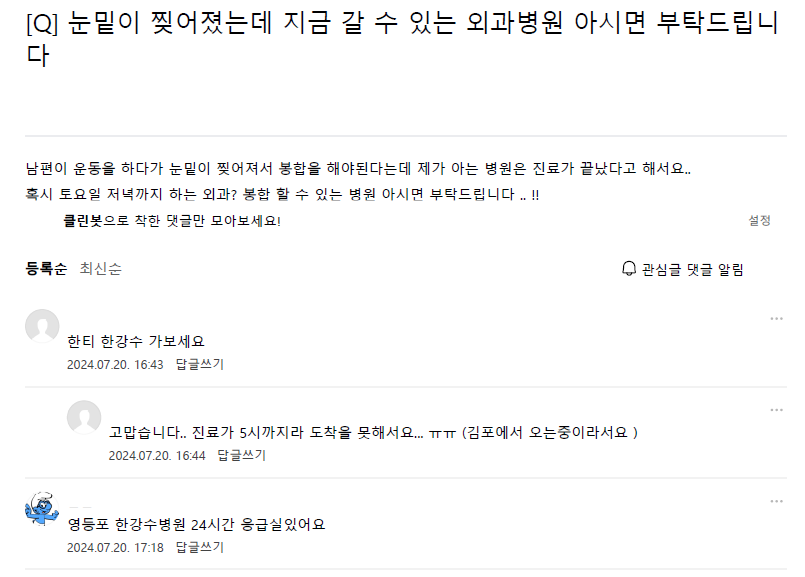

In [54]:
response = agent_executor.invoke(
    {"input": "눈밑이 찢어졌는데 지금 갈 수 있는 외과병원 알려줘."}
)
print(f'답변: {response["output"]}')



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': '지금 바로 갈 수 있는 외과병원'}`


[{'url': 'http://barudahospital.com/', 'content': '바르다정형외과는 환자분의 입장에서 생각합니다. 70,000명. 바르다정형외과는의술과 인술을 겸비한 정형외과 전문의로 이루어진 병원입니다. 환자의 눈높이에 맞추어 충분한 설명 후 진료를 진행합니다. 인공관절 수술. 5,000 례 이상. blue. 관절 내시경 수술. 10,000 ...'}, {'url': 'http://seoul.barunsesang.co.kr/', 'content': '오시는길. 서울시 금천구 시흥대로 421 (독산동 288-1) 서울바른세상병원. 의료진소개 풍부한 임상경험을 갖춘 분야별 전문의들로. 구성된 서울바른세상병원의 의료진. 입원시설 안내 1인 1모니터 와 개인 시설. 환자 중심의 입원 시설과 편의시설.'}, {'url': 'http://the-os.co.kr/', 'content': "더정형외과 병원소개. 고맙습니다, 이 한마디가 당신과 나의 믿음이 되도록 '곧음과 유연'은 더정형외과의 진료 철학입니다. 곧은 척추, 유연한 관절을 만들기 위해 바르고 정직한 진료를 추구합니다. 환자와 유연하게 소통할 수 있는 더정형외과가 되겠습니다."}, {'url': 'https://www.snuh.org/reservation/meddept/TRS/mainIntro.do', 'content': '외상외과 의료진은 중증외상 환자 치료를 위하여 초기 소생술, 응급 시술 및 수술, 중환자실 집중치료 등을 시행하여 외상환자의 생명을 지켜 주어진 삶을 이어나가며, 가정과 직장으로 복귀할 수 있도록 최선을 다하고 있습니다. 또한 서울대학교병원 외상 ...'}, {'url': 'https://cheilos.com/', 'content': "쉽고 빠른 진료예약 바